In [43]:
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from getpass import getpass
from urllib.parse import quote_plus  # URL-encoding

# These info is to access my database. In your case at least the password is different.
host = "localhost"
database = "geoinformaticinsociety"
user = "postgres"
password = getpass("Enter your password: ")

# URL-encode the password to ensure special characters are handled correctly
encoded_password = quote_plus(password)

connection_string = f"postgresql://{user}:{encoded_password}@{host}/{database}"

from sqlalchemy import create_engine

engine = create_engine(connection_string)

from sqlalchemy import inspect

# If you want to use %sql magic in Jupyter
%reload_ext sql
%sql $connection_string
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

# Create a connection to use with psycopg2
conn = psycopg2.connect(connection_string)

# Create a cursor to execute SQL queries
cursor = conn.cursor()

Enter your password:  ········


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11956\1258851332.py:143: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


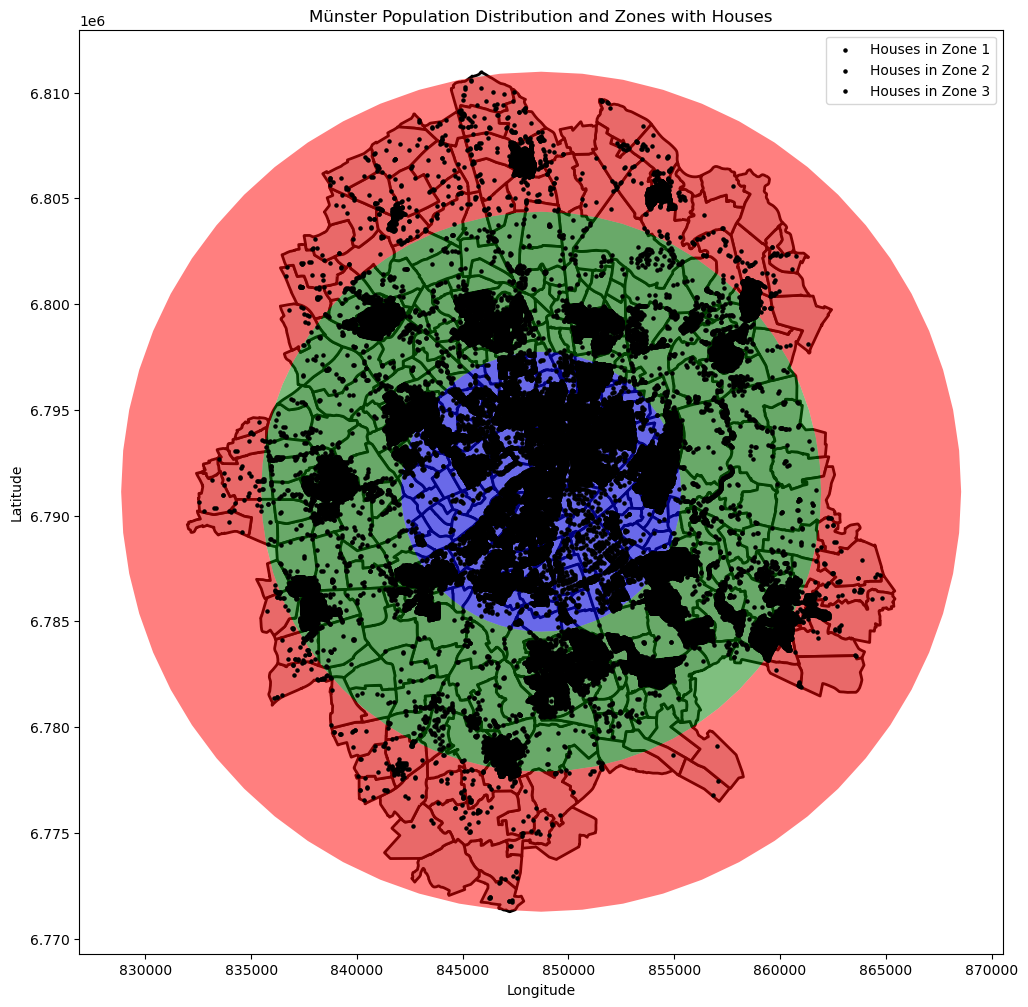

Number of houses in Zone 1: 28421
Number of houses in Zone 2: 32678
Number of houses in Zone 3: 4108
Population per house in Zone 1: 4.28
Population per house in Zone 2: 4.65
Population per house in Zone 3: 7.39


In [79]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from sqlalchemy import text

# Step 1: Load the Münster districts and houses data
munster_districts_gdf = gpd.read_postgis("SELECT * FROM munster_districts_3857", engine, geom_col='geometry')
houses_gdf = gpd.read_postgis("SELECT * FROM houses_3857", engine, geom_col='geometry')

# Step 2: Create three circular zones based on Münster's boundary
munster_bounds = munster_districts_gdf.total_bounds
center_x = (munster_bounds[0] + munster_bounds[2]) / 2
center_y = (munster_bounds[1] + munster_bounds[3]) / 2
district_center = Point(center_x, center_y)

max_radius = max(munster_bounds[2] - munster_bounds[0], munster_bounds[3] - munster_bounds[1]) / 2
radius_1 = max_radius / 3  # Inner circle radius
radius_2 = 2 * max_radius / 3  # Middle circle radius
radius_3 = max_radius  # Outer circle radius

zone_1 = district_center.buffer(radius_1)
zone_2 = district_center.buffer(radius_2).difference(zone_1)
zone_3 = district_center.buffer(radius_3).difference(zone_2.union(zone_1))

zone_1_gdf = gpd.GeoDataFrame({'geometry': [zone_1]}, crs="EPSG:3857")
zone_2_gdf = gpd.GeoDataFrame({'geometry': [zone_2]}, crs="EPSG:3857")
zone_3_gdf = gpd.GeoDataFrame({'geometry': [zone_3]}, crs="EPSG:3857")

# Step 3: Define population distribution
total_population = 303772
population_zone_1 = total_population * 0.40
population_zone_2 = total_population * 0.50
population_zone_3 = total_population * 0.10

def distribute_population(zone_gdf, population):
    houses_in_zone = gpd.sjoin(houses_gdf, zone_gdf, how="inner", predicate="intersects")
    num_houses = len(houses_in_zone)
    if num_houses > 0:
        houses_in_zone['population'] = population / num_houses
        return houses_in_zone, num_houses, population / num_houses
    else:
        return None, 0, 0

# Assign population per house
houses_zone_1, num_houses_zone_1, pop_per_house_zone_1 = distribute_population(zone_1_gdf, population_zone_1)
houses_zone_2, num_houses_zone_2, pop_per_house_zone_2 = distribute_population(zone_2_gdf, population_zone_2)
houses_zone_3, num_houses_zone_3, pop_per_house_zone_3 = distribute_population(zone_3_gdf, population_zone_3)

# Combine results
all_houses_with_population = pd.concat([houses_zone_1, houses_zone_2, houses_zone_3])

# Step 4: Add population data to houses_3857
def assign_population_to_houses(houses_gdf, zone_1_gdf, zone_2_gdf, zone_3_gdf, pop_per_house_zone_1, pop_per_house_zone_2, pop_per_house_zone_3):
    # For each zone, find the houses that fall within the zone
    houses_in_zone_1 = gpd.sjoin(houses_gdf, zone_1_gdf, how="inner", predicate="intersects")
    houses_in_zone_2 = gpd.sjoin(houses_gdf, zone_2_gdf, how="inner", predicate="intersects")
    houses_in_zone_3 = gpd.sjoin(houses_gdf, zone_3_gdf, how="inner", predicate="intersects")
    
    # Assign population to the houses in each zone
    houses_in_zone_1['population'] = pop_per_house_zone_1
    houses_in_zone_2['population'] = pop_per_house_zone_2
    houses_in_zone_3['population'] = pop_per_house_zone_3
    
    # Combine all houses with their population
    all_houses_with_population = pd.concat([houses_in_zone_1, houses_in_zone_2, houses_in_zone_3])
    return all_houses_with_population

# Add the population column to the houses_3857
with conn.cursor() as cursor:
    cursor.execute(f"""
        ALTER TABLE houses_3857
        ADD COLUMN population FLOAT DEFAULT 0;
    """)
    conn.commit()

from shapely import wkt

# Update houses_3857 table with population data based on geometry
temp_table = "houses_3857"
with conn.cursor() as cursor:
    for _, row in all_houses_with_population.iterrows():
        # Convert the geometry to WKT format
        geometry_wkt = row['geometry'].wkt
        
        # Update the population based on the geometry matching
        cursor.execute(f"""
            UPDATE {temp_table}
            SET population = %s
            WHERE ST_Equals(geometry, ST_GeomFromText(%s, 3857))  -- assuming the CRS is EPSG:3857
        """, (row['population'], geometry_wkt))
    
    conn.commit()  # Commit the changes after the loop

# Step 5: Add population-related columns to munster_districts_3857
temp_districts_table = "munster_districts_3857"
with conn.cursor() as cursor:
    cursor.execute(f"""
        ALTER TABLE {temp_districts_table} 
        ADD COLUMN IF NOT EXISTS house_count INTEGER DEFAULT 0, 
        ADD COLUMN IF NOT EXISTS district_population FLOAT DEFAULT 0, 
        ADD COLUMN IF NOT EXISTS population_score FLOAT DEFAULT 0;
    """)
    conn.commit()  # Commit the changes after ALTER TABLE

# Step 6: Update munster_districts_3857 with house count, district population, and population score
with conn.cursor() as cursor:
    cursor.execute(f"""
        UPDATE {temp_districts_table} AS m
        SET house_count = sub.house_count,
            district_population = sub.district_population,
            population_score = sub.district_population / {total_population}
        FROM (
            SELECT 
                m.geometry,
                COALESCE(COUNT(h.geometry), 0) AS house_count,
                COALESCE(SUM(h.population), 0) AS district_population
            FROM {temp_districts_table} AS m
            LEFT JOIN houses_3857 AS h
            ON ST_Intersects(m.geometry, h.geometry)
            GROUP BY m.geometry
        ) AS sub
        WHERE ST_Intersects(m.geometry, sub.geometry);
    """)
    conn.commit()  # Commit the changes after UPDATE

# Step 7: Plot the data
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the Münster districts with population and zones
munster_districts_gdf.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=2)
zone_1_gdf.plot(ax=ax, color='blue', alpha=0.5, label="Zone 1 (40% Population)")
zone_2_gdf.plot(ax=ax, color='green', alpha=0.5, label="Zone 2 (50% Population)")
zone_3_gdf.plot(ax=ax, color='red', alpha=0.5, label="Zone 3 (10% Population)")

# Plot houses in each zone
houses_zone_1.plot(ax=ax, color='black', markersize=5, label="Houses in Zone 1")
houses_zone_2.plot(ax=ax, color='black', markersize=5, label="Houses in Zone 2")
houses_zone_3.plot(ax=ax, color='black', markersize=5, label="Houses in Zone 3")

# Add labels and title to the plot
plt.title("Münster Population Distribution and Zones with Houses")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Print statistics for the zones
print(f"Number of houses in Zone 1: {num_houses_zone_1}")
print(f"Number of houses in Zone 2: {num_houses_zone_2}")
print(f"Number of houses in Zone 3: {num_houses_zone_3}")
print(f"Population per house in Zone 1: {pop_per_house_zone_1:.2f}")
print(f"Population per house in Zone 2: {pop_per_house_zone_2:.2f}")
print(f"Population per house in Zone 3: {pop_per_house_zone_3:.2f}")

In [77]:
conn.rollback()